In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skbio.diversity
import seaborn as sns
from scipy.stats import wilcoxon
#from skbio.diversity import subsample_counts

In [7]:
df = pd.read_csv(r"..\..\Data_prep\FINAL_UNASSIGNED_RAW.csv")

In [8]:
mapping = pd.read_excel("../../../OralMicrobiome_SG90/Full_data/6_taxonomy_community/feature_taxonomy_split.xlsx")

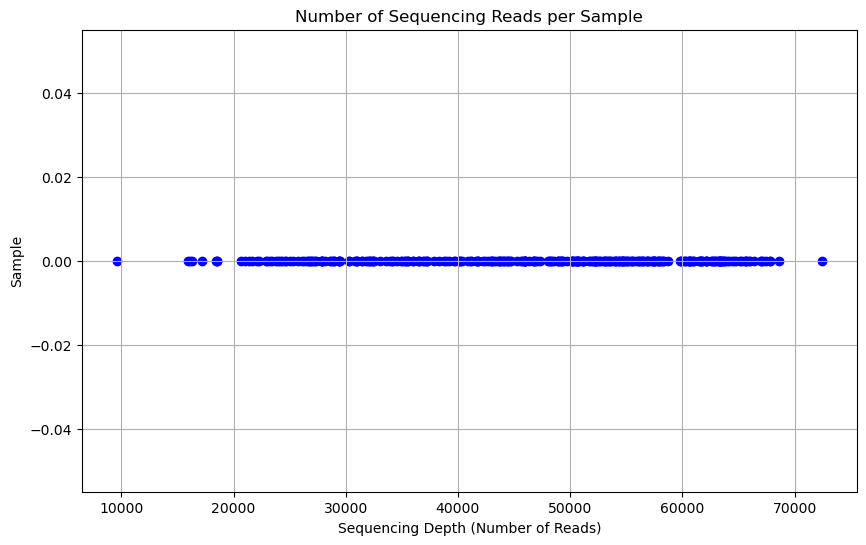

In [9]:
#figure out appropriate sampling depth for Rarefaction
reads = df.iloc[:,:-13]
reads['Row_Sum'] = reads.iloc[:,1:].sum(axis=1)
df['Row_Sum'] = reads.iloc[:,1:].sum(axis=1)

# Plotting the sequencing depth for each sample
plt.figure(figsize=(10, 6))
plt.scatter(reads['Row_Sum'], np.zeros(311), color='blue')

# Adding labels and title
plt.xlabel('Sequencing Depth (Number of Reads)')
plt.ylabel('Sample')
plt.title('Number of Sequencing Reads per Sample')

# Show the plot
plt.grid(True)
plt.show()

In [10]:
#figure out exact number of breaking point
depths = reads["Row_Sum"][reads["Row_Sum"] > 20000]
rarefaction_depth = depths.sort_values()[0]

In [6]:
rarefaction_depth

23806

C:\Users\wehne\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\wehne\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


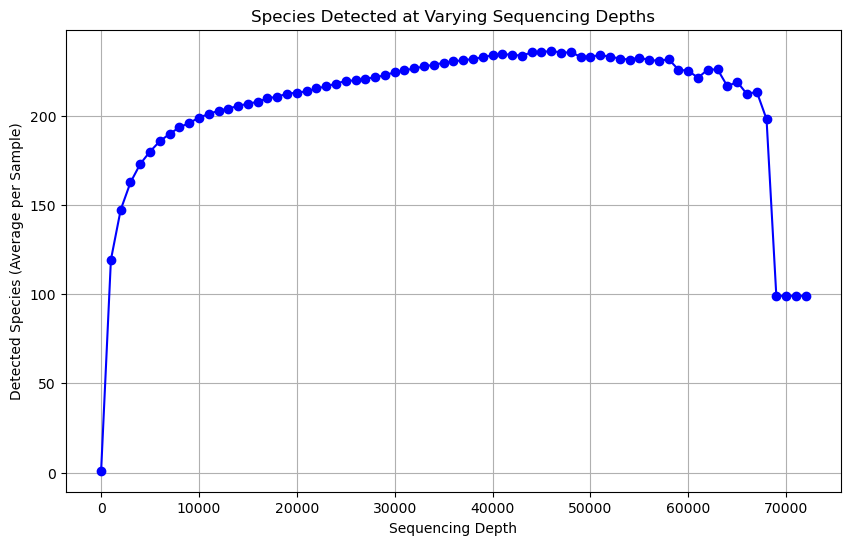

In [64]:
#confirm that not too much information is lost at that rarefaction level

# Convert microbiome data to integer values
microbiome_data = df.iloc[:, 1:-13].astype(int).values

# Function to manually perform rarefaction by randomly selecting reads without replacement
def rarefy_counts(counts, depth):
    # If the total reads are less than or equal to the target depth, return all the counts
    if np.sum(counts) <= depth:
        return counts
    # Otherwise, randomly select indices to subsample
    non_zero_indices = np.where(counts > 0)[0]
    reads_to_sample = np.repeat(non_zero_indices, counts[non_zero_indices])
    sampled_reads = np.random.choice(reads_to_sample, depth, replace=False)
    rarefied_counts = np.bincount(sampled_reads, minlength=len(counts))
    return rarefied_counts

# Define the range of sequencing depths to test (from minimum to max in steps of 500)
depths_to_test = np.arange(1, df['Row_Sum'].max() + 1, step=1000)

# Function to calculate the number of detected species at a given depth
def detected_species_at_depth(counts, depth):
    rarefied_counts = rarefy_counts(counts, depth)
    detected_species = np.sum(rarefied_counts > 0)  # Count non-zero entries (detected species)
    return detected_species

# Initialize an empty list to store results
detected_species = []

# Loop over each sequencing depth and compute detected species
for depth in depths_to_test:
    species_counts = []
    for sample in microbiome_data:
        # Only consider samples with more than the current depth
        if np.sum(sample) >= depth:
            species_counts.append(detected_species_at_depth(sample, depth))
    # Average number of detected species across samples
    detected_species.append(np.mean(species_counts))

# Create a DataFrame with the results
species_detected_df = pd.DataFrame({'Sequencing_Depth': depths_to_test, 'Detected_Species': detected_species})

# Plot the rarefaction curve
plt.figure(figsize=(10, 6))
plt.plot(depths_to_test, detected_species, marker='o', linestyle='-', color='blue')
plt.xlabel('Sequencing Depth')
plt.ylabel('Detected Species (Average per Sample)')
plt.title('Species Detected at Varying Sequencing Depths')
plt.grid(True)
plt.show()


In [11]:
# Step 1: Create a dictionary to map feature IDs to species
feature_to_species = dict(zip(mapping['feature ID'], mapping['Species']))

# Step 2: Initialize a dictionary to store species read data
species_data = {}

# Step 3: Aggregate reads by species
for feature_id in df.columns[1:-14]:
    species = feature_to_species.get(feature_id, None)  # Get the species name for the feature ID
    if species:
        if species not in species_data:
            # If species doesn't exist, initialize with the feature data
            species_data[species] = df[feature_id].copy()
        else:
            # If species already exists, add the feature's reads to the existing species data
            species_data[species] += df[feature_id]

# Step 4: Convert the species_data dictionary to a DataFrame
species_df = pd.DataFrame(species_data, index=df.index)

# Step 5: Add back non-feature columns (the ones not in df.columns[1:-14])
non_feature_columns = df.columns[:1].tolist() + df.columns[-14:].tolist()
species_df = pd.concat([df[non_feature_columns], species_df], axis=1)

# De-fragment the DataFrame to improve performance
species_df = species_df.copy()
species_df.to_csv("FINAL_SPECIES_RAW.csv", index = False)

In [88]:
# Step 1: Extract feature counts and rarefaction depth
feature_counts = df.iloc[:, 1:-14]  # Unassigned feature IDs counts
rarefaction_depth = rarefaction_depth  # Assuming rarefaction_depth is defined
iterations = 100  # Number of rarefaction iterations
groups = df['Group']  # Assuming your group column is labeled as 'Group'

# Step 2: Drop samples with total counts < rarefaction_depth
sufficient_counts = feature_counts[feature_counts.sum(axis=1) >= rarefaction_depth]
remaining_samples = sufficient_counts.shape[0]
print(f"Number of samples remaining after rarefaction: {remaining_samples}")

# Step 3: Define the rarefaction function with iterations
def rarefy_counts_with_iterations(row, depth, iterations):
    if row.sum() < depth:
        return row
    rarefied_matrices = []
    non_zero_indices = np.where(row > 0)[0]
    
    for _ in range(iterations):
        counts_to_sample = []
        for idx in non_zero_indices:
            counts_to_sample.extend([idx] * row[idx])
        rarefied_counts = np.random.choice(counts_to_sample, depth, replace=False)
        rarefied_row = np.zeros_like(row)
        unique, counts = np.unique(rarefied_counts, return_counts=True)
        rarefied_row[unique] = counts
        rarefied_matrices.append(rarefied_row)
    
    return np.mean(rarefied_matrices, axis=0)

# Step 4: Apply rarefaction to the filtered samples
rarefied_counts = sufficient_counts.apply(lambda row: rarefy_counts_with_iterations(row.values, rarefaction_depth, iterations), axis=1)
rarefied_counts_df = pd.DataFrame(rarefied_counts.tolist(), columns=feature_counts.columns, index=sufficient_counts.index)

# Step 5: Group samples by group for further analysis
grouped_data = rarefied_counts_df.join(df['Group'])  # Add group information


Number of samples remaining after rarefaction: 293


Wilcoxon test p-value = nan


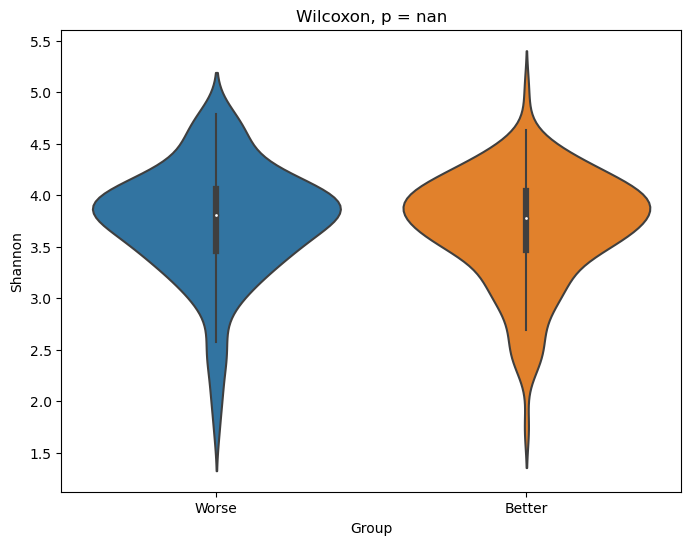

In [89]:
import seaborn as sns
from scipy.stats import wilcoxon

# Step 6: Calculate alpha diversity metrics (Shannon Index in this case)
alpha_diversity = calculate_alpha_diversity(rarefied_counts_df)

# Step 7: Merge diversity results with group information
alpha_diversity['Group'] = df['Group']  # Assuming 'Group' column contains group labels

# Step 8: Perform Wilcoxon test
group1 = alpha_diversity[alpha_diversity['Group'] == 'Group1']['Shannon']
group2 = alpha_diversity[alpha_diversity['Group'] == 'Group2']['Shannon']
stat, p_value = wilcoxon(group1, group2)
print(f"Wilcoxon test p-value = {p_value}")

# Step 9: Violin plot grouped by group
plt.figure(figsize=(8, 6))
sns.violinplot(x='Group', y='Shannon', data=alpha_diversity, inner='box')
plt.title(f'Wilcoxon, p = {p_value:.2f}')
plt.savefig('violin_plot_grouped.png')
plt.show()


Total samples remaining after filtering: 293
Samples in 'Better' group: 144
Samples in 'Worse' group: 149
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


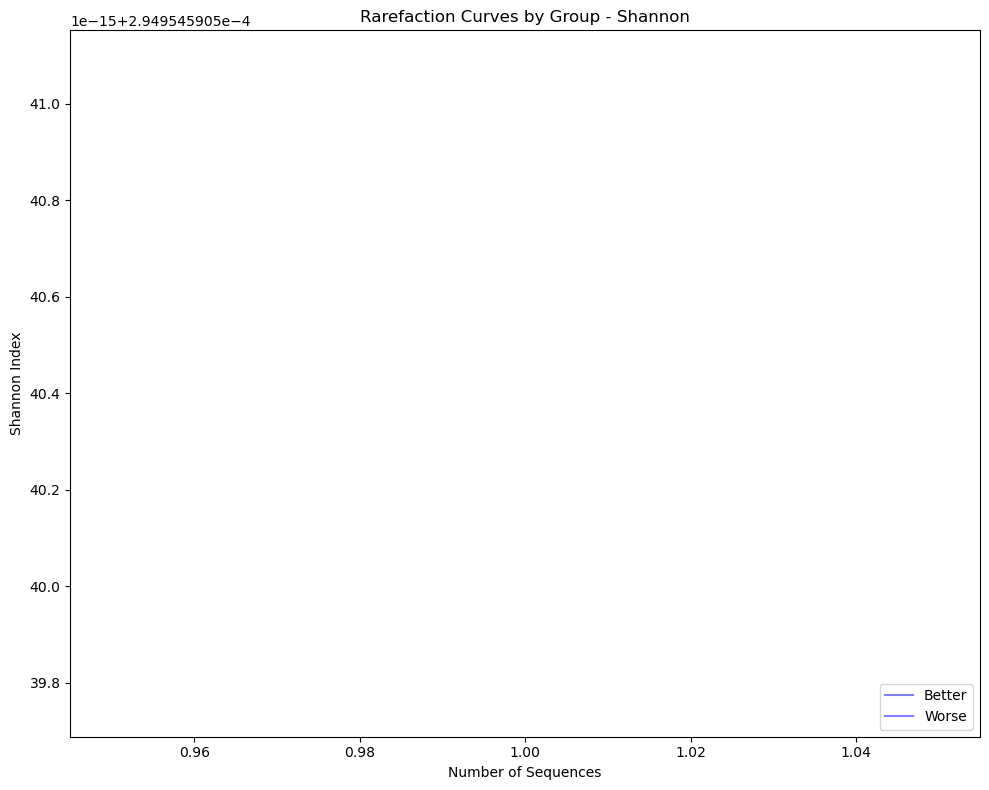

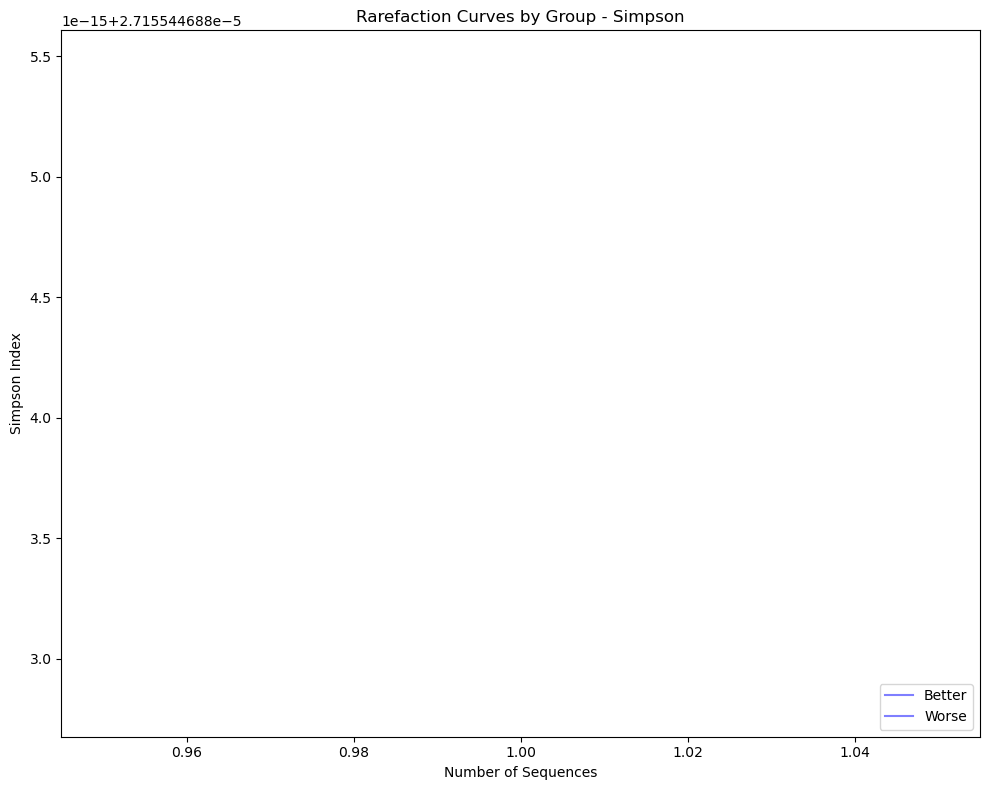

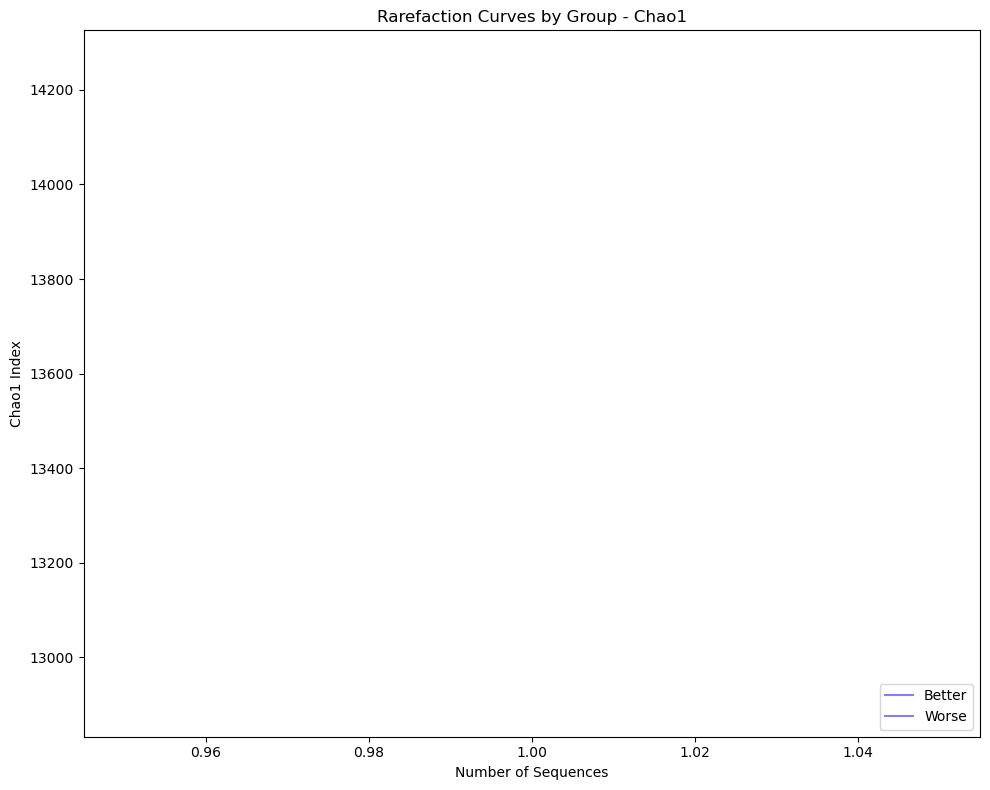

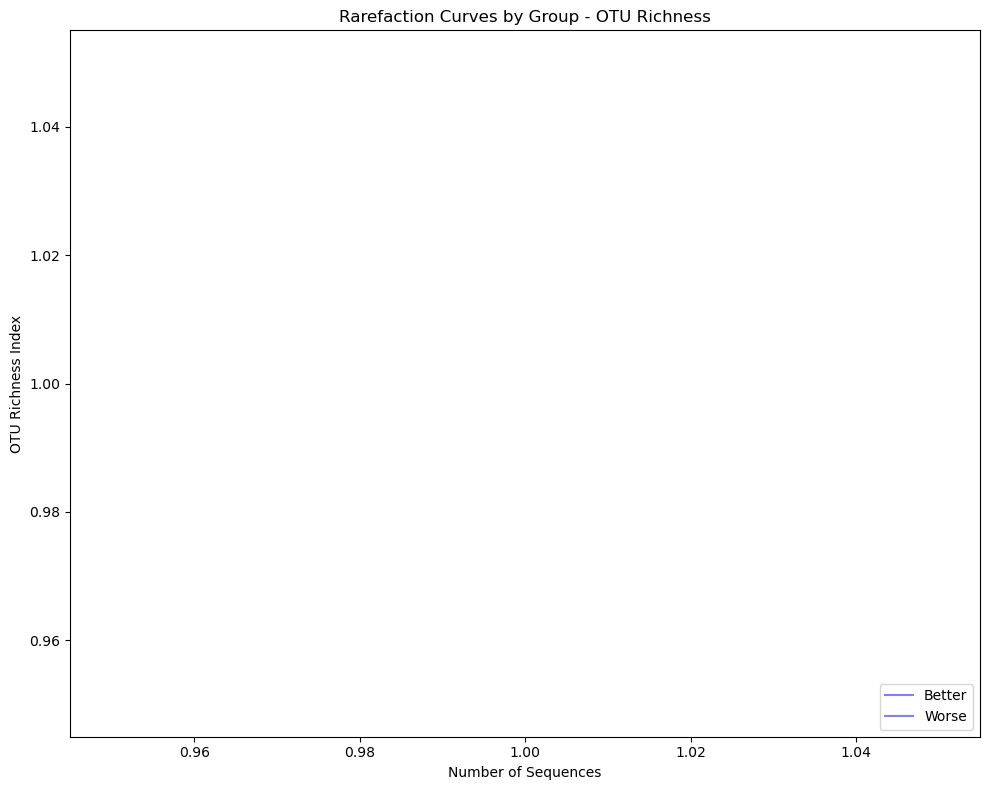

In [6]:
# Step 1: Filter samples with fewer total reads than the rarefaction depth
def filter_samples_by_depth(counts_df, depth):
    """
    Filter samples that have fewer total reads than the specified rarefaction depth.
    """
    filtered_df = counts_df[counts_df.sum(axis=1) >= depth]
    return filtered_df

# Step 2: Rarefaction function to subsample counts at various depths and calculate multiple diversity metrics
def rarefaction_curve(counts, depths, iterations=2):
    """
    Perform rarefaction on a single sample for a range of depths and return the Shannon, Simpson, Chao1, and OTU richness at each depth.
    """
    rarefied_shannon = []
    rarefied_simpson = []
    rarefied_chao1 = []
    rarefied_otu = []
    total_depth = counts.sum()
    
    for depth in depths:
        shannon_at_depth = []
        simpson_at_depth = []
        chao1_at_depth = []
        otu_at_depth = []
        
        if total_depth < depth:
            # Not enough sequences for this depth
            rarefied_shannon.append(np.nan)
            rarefied_simpson.append(np.nan)
            rarefied_chao1.append(np.nan)
            rarefied_otu.append(np.nan)
            continue
        
        non_zero_counts = counts[counts > 0]  # Only use non-zero counts
        if len(non_zero_counts) < depth:
            # If fewer non-zero entries than depth, skip this depth
            rarefied_shannon.append(np.nan)
            rarefied_simpson.append(np.nan)
            rarefied_chao1.append(np.nan)
            rarefied_otu.append(np.nan)
            continue

        for _ in range(iterations):
            print("hi")
            subsample = np.random.choice(np.arange(len(counts)), size=depth, p=counts/counts.sum(), replace=False)
            subsampled_counts = np.bincount(subsample, minlength=len(counts))
            
            # Calculate metrics
            shannon_at_depth.append(skbio.diversity.alpha.shannon(subsampled_counts + 1e-9))
            simpson_at_depth.append(skbio.diversity.alpha.simpson(subsampled_counts + 1e-9))
            chao1_at_depth.append(skbio.diversity.alpha.chao1(subsampled_counts + 1e-9))
            otu_at_depth.append((subsampled_counts > 0).sum())
        
        # Average over iterations
        rarefied_shannon.append(np.mean(shannon_at_depth))
        rarefied_simpson.append(np.mean(simpson_at_depth))
        rarefied_chao1.append(np.mean(chao1_at_depth))
        rarefied_otu.append(np.mean(otu_at_depth))
    
    return rarefied_shannon, rarefied_simpson, rarefied_chao1, rarefied_otu

# Step 3: Define the range of depths for rarefaction
max_depth = rarefaction_depth  # Maximum rarefaction depth
depths = np.linspace(1, max_depth, num=5, dtype=int)  # Adjust the number of depths as needed

# Step 4: Calculate rarefaction curves for each sample
def calculate_rarefaction_curves(counts_df, depths, iterations=1):
    shannon_results = []
    simpson_results = []
    chao1_results = []
    otu_results = []
    
    for index, row in counts_df.iterrows():
        shannon, simpson, chao1, otu = rarefaction_curve(row.values, depths, iterations)
        shannon_results.append(shannon)
        simpson_results.append(simpson)
        chao1_results.append(chao1)
        otu_results.append(otu)
    
    return np.array(shannon_results), np.array(simpson_results), np.array(chao1_results), np.array(otu_results)

# Step 5: Group data based on conditions and filter based on rarefaction depth
# Ensure your DataFrame df has a 'Group' column with 'Better' and 'Worse' group labels

# Filter samples by rarefaction depth
group1_counts = df[df['Group'] == 'Better'].iloc[:, 1:-14]  # Feature counts for Group 1 (Better)
group2_counts = df[df['Group'] == 'Worse'].iloc[:, 1:-14]   # Feature counts for Group 2 (Worse)

# Apply filtering to remove samples with fewer reads than rarefaction depth
group1_filtered = filter_samples_by_depth(group1_counts, rarefaction_depth)
group2_filtered = filter_samples_by_depth(group2_counts, rarefaction_depth)

# Print how many samples remain
total_samples = group1_filtered.shape[0] + group2_filtered.shape[0]
group1_samples = group1_filtered.shape[0]
group2_samples = group2_filtered.shape[0]
print(f"Total samples remaining after filtering: {total_samples}")
print(f"Samples in 'Better' group: {group1_samples}")
print(f"Samples in 'Worse' group: {group2_samples}")

# Step 6: Calculate rarefaction curves for both groups
group1_shannon, group1_simpson, group1_chao1, group1_otu = calculate_rarefaction_curves(group1_filtered, depths)
group2_shannon, group2_simpson, group2_chao1, group2_otu = calculate_rarefaction_curves(group2_filtered, depths)

# Step 7: Plot rarefaction curves for all metrics
metrics = ['Shannon', 'Simpson', 'Chao1', 'OTU Richness']
group1_results = [group1_shannon, group1_simpson, group1_chao1, group1_otu]
group2_results = [group2_shannon, group2_simpson, group2_chao1, group2_otu]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(10, 8))
    
    # Group 1 rarefaction curves
    for j in range(group1_results[i].shape[0]):
        plt.plot(depths, group1_results[i][j], color='blue', alpha=0.5)
    
    # Group 2 rarefaction curves
    for j in range(group2_results[i].shape[0]):
        plt.plot(depths, group2_results[i][j], color='red', alpha=0.5)
    
    # Add plot details
    plt.title(f'Rarefaction Curves by Group - {metric}')
    plt.xlabel('Number of Sequences')
    plt.ylabel(f'{metric} Index')
    plt.legend(['Better', 'Worse'], loc='lower right')
    plt.tight_layout()
    plt.savefig(f'rarefaction_curves_by_group_{metric}.png')
    plt.show()
